## Setup & Imports

In [13]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# Import des modules du projet
from src.detection import GroundingDINODetector
from src.segmentation import SAMSegmenter
from ultralytics.models import YOLO

## Configuration

In [14]:
# Chemins des modèles
YOLO_MODEL = "runs/segment/ball_person_model/weights/best.pt"  # Modèle entraîné

# Dossier d'images à tester
TEST_IMAGES_DIR = Path("datasets/raw/IRL_validation_pictures")

# Prompt pour GroundingDINO
DETECTION_PROMPT = "red ball . human"


# Output
OUTPUT_DIR = Path("demo_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

## Load Models

In [15]:

# Seuils de confiance
GDINO_BOX_THRESHOLD = 0.116
GDINO_TEXT_THRESHOLD = 0.06
YOLO_CONF = 0.25

gdino = GroundingDINODetector(
    box_threshold=GDINO_BOX_THRESHOLD,
    text_threshold=GDINO_TEXT_THRESHOLD
)

final text_encoder_type: bert-base-uncased


## Utility Functions

In [16]:
def draw_boxes(image, detections, color=(0, 255, 0)):
    """
    Dessine les bounding boxes sur l'image avec adaptation automatique de la taille
    
    Args:
        image: Image numpy (BGR)
        detections: Liste de dict avec 'bbox', 'label', 'confidence'
        color: Tuple (B, G, R) pour la couleur des boxes
    """
    img_copy = image.copy()
    h, w = img_copy.shape[:2]
    
    # Calculer l'échelle basée sur la taille de l'image (référence: 1000px)
    scale_factor = max(h, w) / 1000.0
    
    # Paramètres adaptatifs ajustés (plus petits)
    thickness = max(1, int(2 * scale_factor))
    font_scale = max(0.4, 0.6 * scale_factor)
    font_thickness = max(1, int(1.5 * scale_factor))
    padding = max(2, int(5 * scale_factor))
    
    for det in detections:
        bbox = det['bbox']
        label = det['label']
        conf = det['confidence']
        
        x1, y1, x2, y2 = map(int, bbox)
        
        # Rectangle
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)
        
        # Label
        text = f"{label}: {conf:.2f}"
        (tw, th), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        
        # Position du label
        label_y = y1 - padding
        
        # Si le label sort en haut, le mettre en dessous
        if label_y - th - padding < 0:
            label_y = y2 + th + padding
            
        # Fond du label
        cv2.rectangle(img_copy, 
                     (x1, label_y - th - padding), 
                     (x1 + tw + padding, label_y + padding//2), 
                     color, -1)
        
        # Texte en NOIR pour contraste
        cv2.putText(img_copy, text, 
                   (x1 + padding//2, label_y - padding//2), 
                   cv2.FONT_HERSHEY_SIMPLEX, 
                   font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    
    return img_copy


def draw_masks(image, masks, alpha=0.5):
    """
    Dessine les masques de segmentation
    
    Args:
        image: Image numpy (BGR)
        masks: Liste de masques numpy (H, W) binaires
    """
    img_copy = image.copy()
    
    # Couleurs différentes pour chaque masque
    colors = [
        (255, 0, 0),    # Rouge
        (0, 255, 0),    # Vert
        (0, 0, 255),    # Bleu
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
    ]
    
    for i, mask in enumerate(masks):
        color = colors[i % len(colors)]
        
        # Créer overlay coloré
        colored_mask = np.zeros_like(img_copy)
        colored_mask[mask > 0] = color
        
        # Blending
        img_copy = cv2.addWeighted(img_copy, 1, colored_mask, alpha, 0)
    
    return img_copy


def visualize_comparison(image_path, gdino_dets, masks=None):
    """
    Visualisation de la détection/segmentation (Image seule)
    
    Args:
        image_path: Path - Chemin vers l'image
        gdino_dets: list - Liste des détections GroundingDINO
        masks: list (optionnel) - Liste des masques SAM2
    """
    # Charger l'image
    image_bgr = cv2.imread(str(image_path))
    
    # Base image
    vis_img = image_bgr.copy()
    
    # Draw masks if present
    if masks is not None and len(masks) > 0:
        vis_img = draw_masks(vis_img, masks, alpha=0.4)
        
    # Draw boxes
    vis_img = draw_boxes(vis_img, gdino_dets, color=(0, 255, 0))
    
    vis_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    
    # Affichage en grand
    fig = plt.figure(figsize=(20, 15))
    plt.imshow(vis_rgb)
    plt.axis('off')
    plt.title(f'{image_path.name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

In [17]:
def quick_test_gdino(image_path, prompt, box_threshold=0.35, text_threshold=0.25):
    """
    Test rapide de GroundingDINO sur une image
    
    Args:
        image_path: str ou Path - Chemin vers l'image
        prompt: str - Prompt de détection (ex: "red ball . person")
        box_threshold: float - Seuil de confiance pour les boxes
        text_threshold: float - Seuil de confiance pour le texte
    
    Returns:
        Figure matplotlib avec l'image et les détections
    """
    from pathlib import Path
    
    # Convertir en Path si nécessaire
    img_path = Path(image_path)
    
    # Créer un détecteur temporaire avec les seuils demandés
    detector = GroundingDINODetector(
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    
    # Détection silencieuse
    dets_dict = detector.detect(img_path, prompt, return_all_by_label=True, debug=False)
    
    # Flatten les détections et compter
    all_dets = []
    counts = {}
    for label, detections in dets_dict.items():
        all_dets.extend(detections)
        counts[label] = len(detections)
    
    # Afficher le résumé en une ligne
    summary = ", ".join(f"{count} {label}" for label, count in counts.items())
    print(f"Found: {summary}")
    
    # Visualiser
    fig = visualize_comparison(img_path, all_dets)
    # plt.show()
    
    return fig

final text_encoder_type: bert-base-uncased
Found: 16 red ball, 0 person


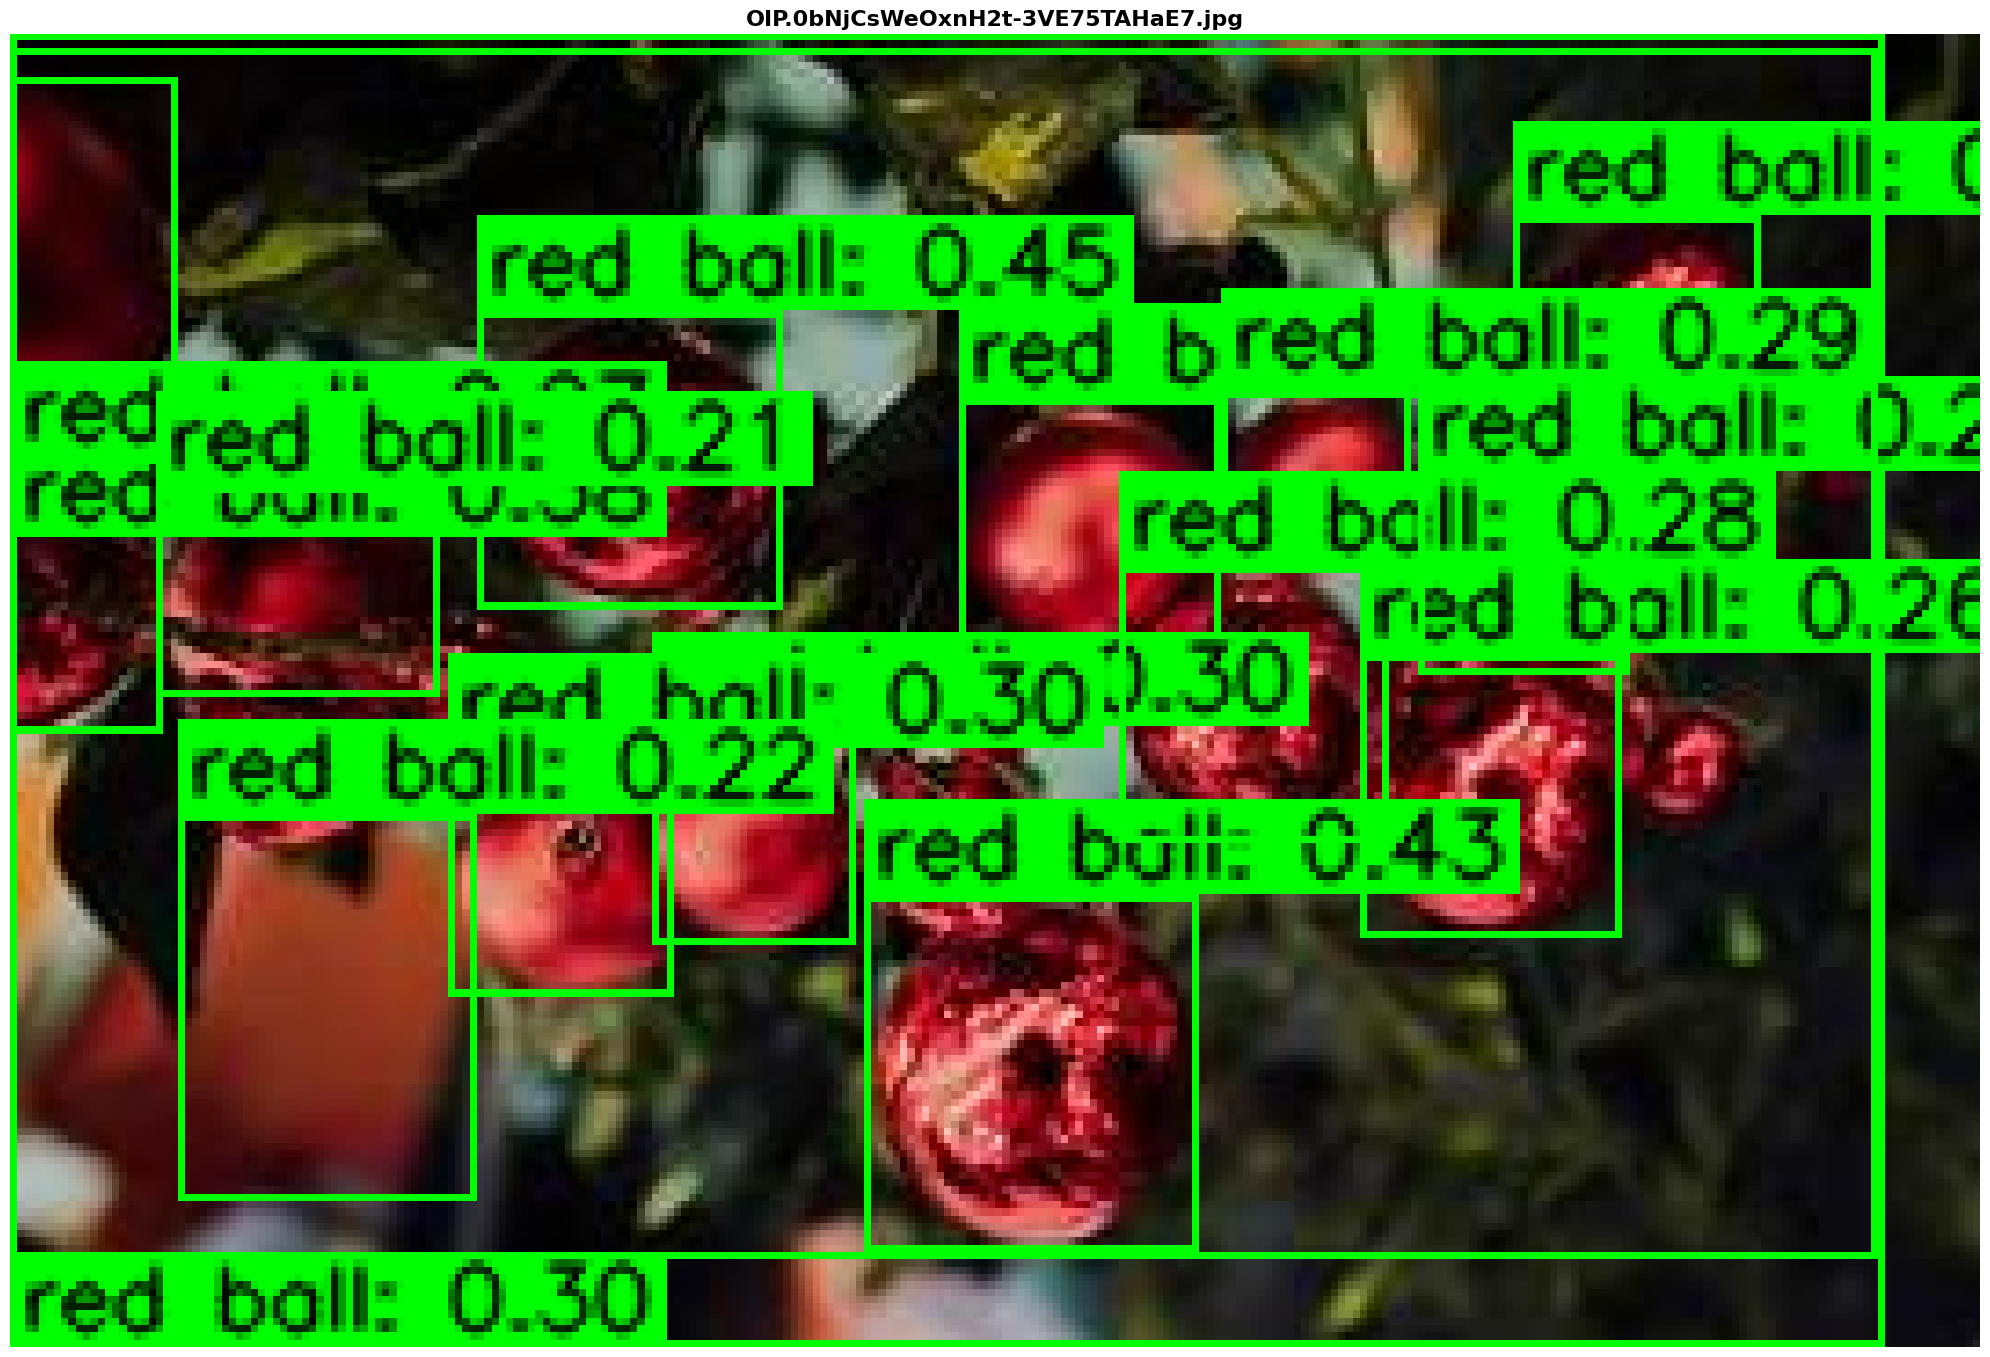

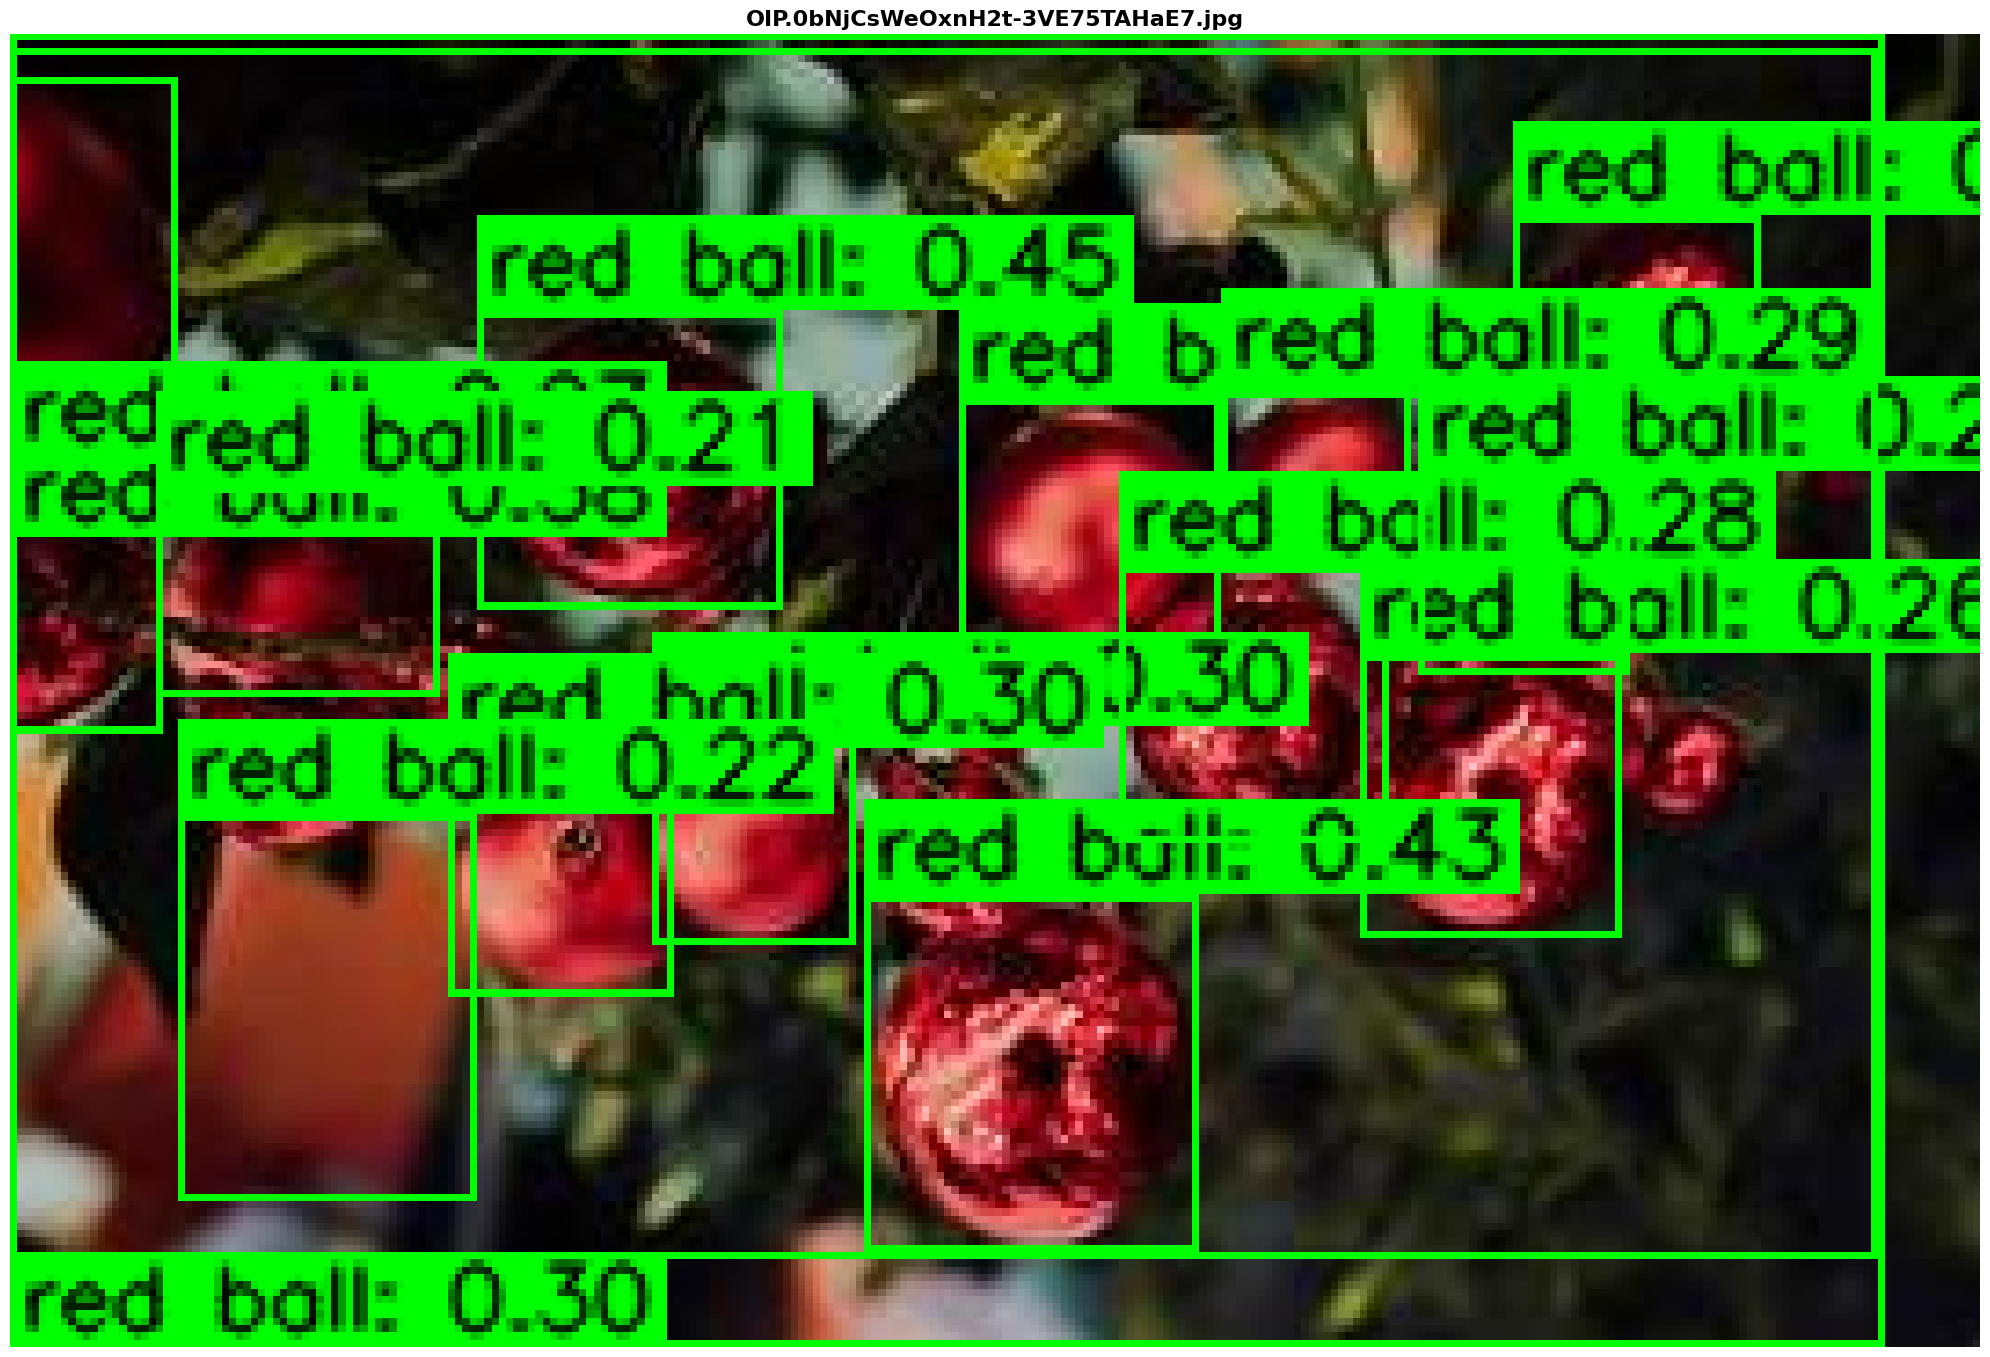

In [29]:
# img = Path("datasets/raw") / "IRL_validation_pictures" / "IMG_9698.JPG"
filename="OIP.0bNjCsWeOxnH2t-3VE75TAHaE7.jpg"
img = Path("datasets/raw") / "red balls human yahoo" / filename

assert img.exists()
quick_test_gdino(img, 
    "red ball . person", 
    box_threshold=0.116, 
    text_threshold=0.2,
)

final text_encoder_type: bert-base-uncased
Found: 1 red ball, 6 person


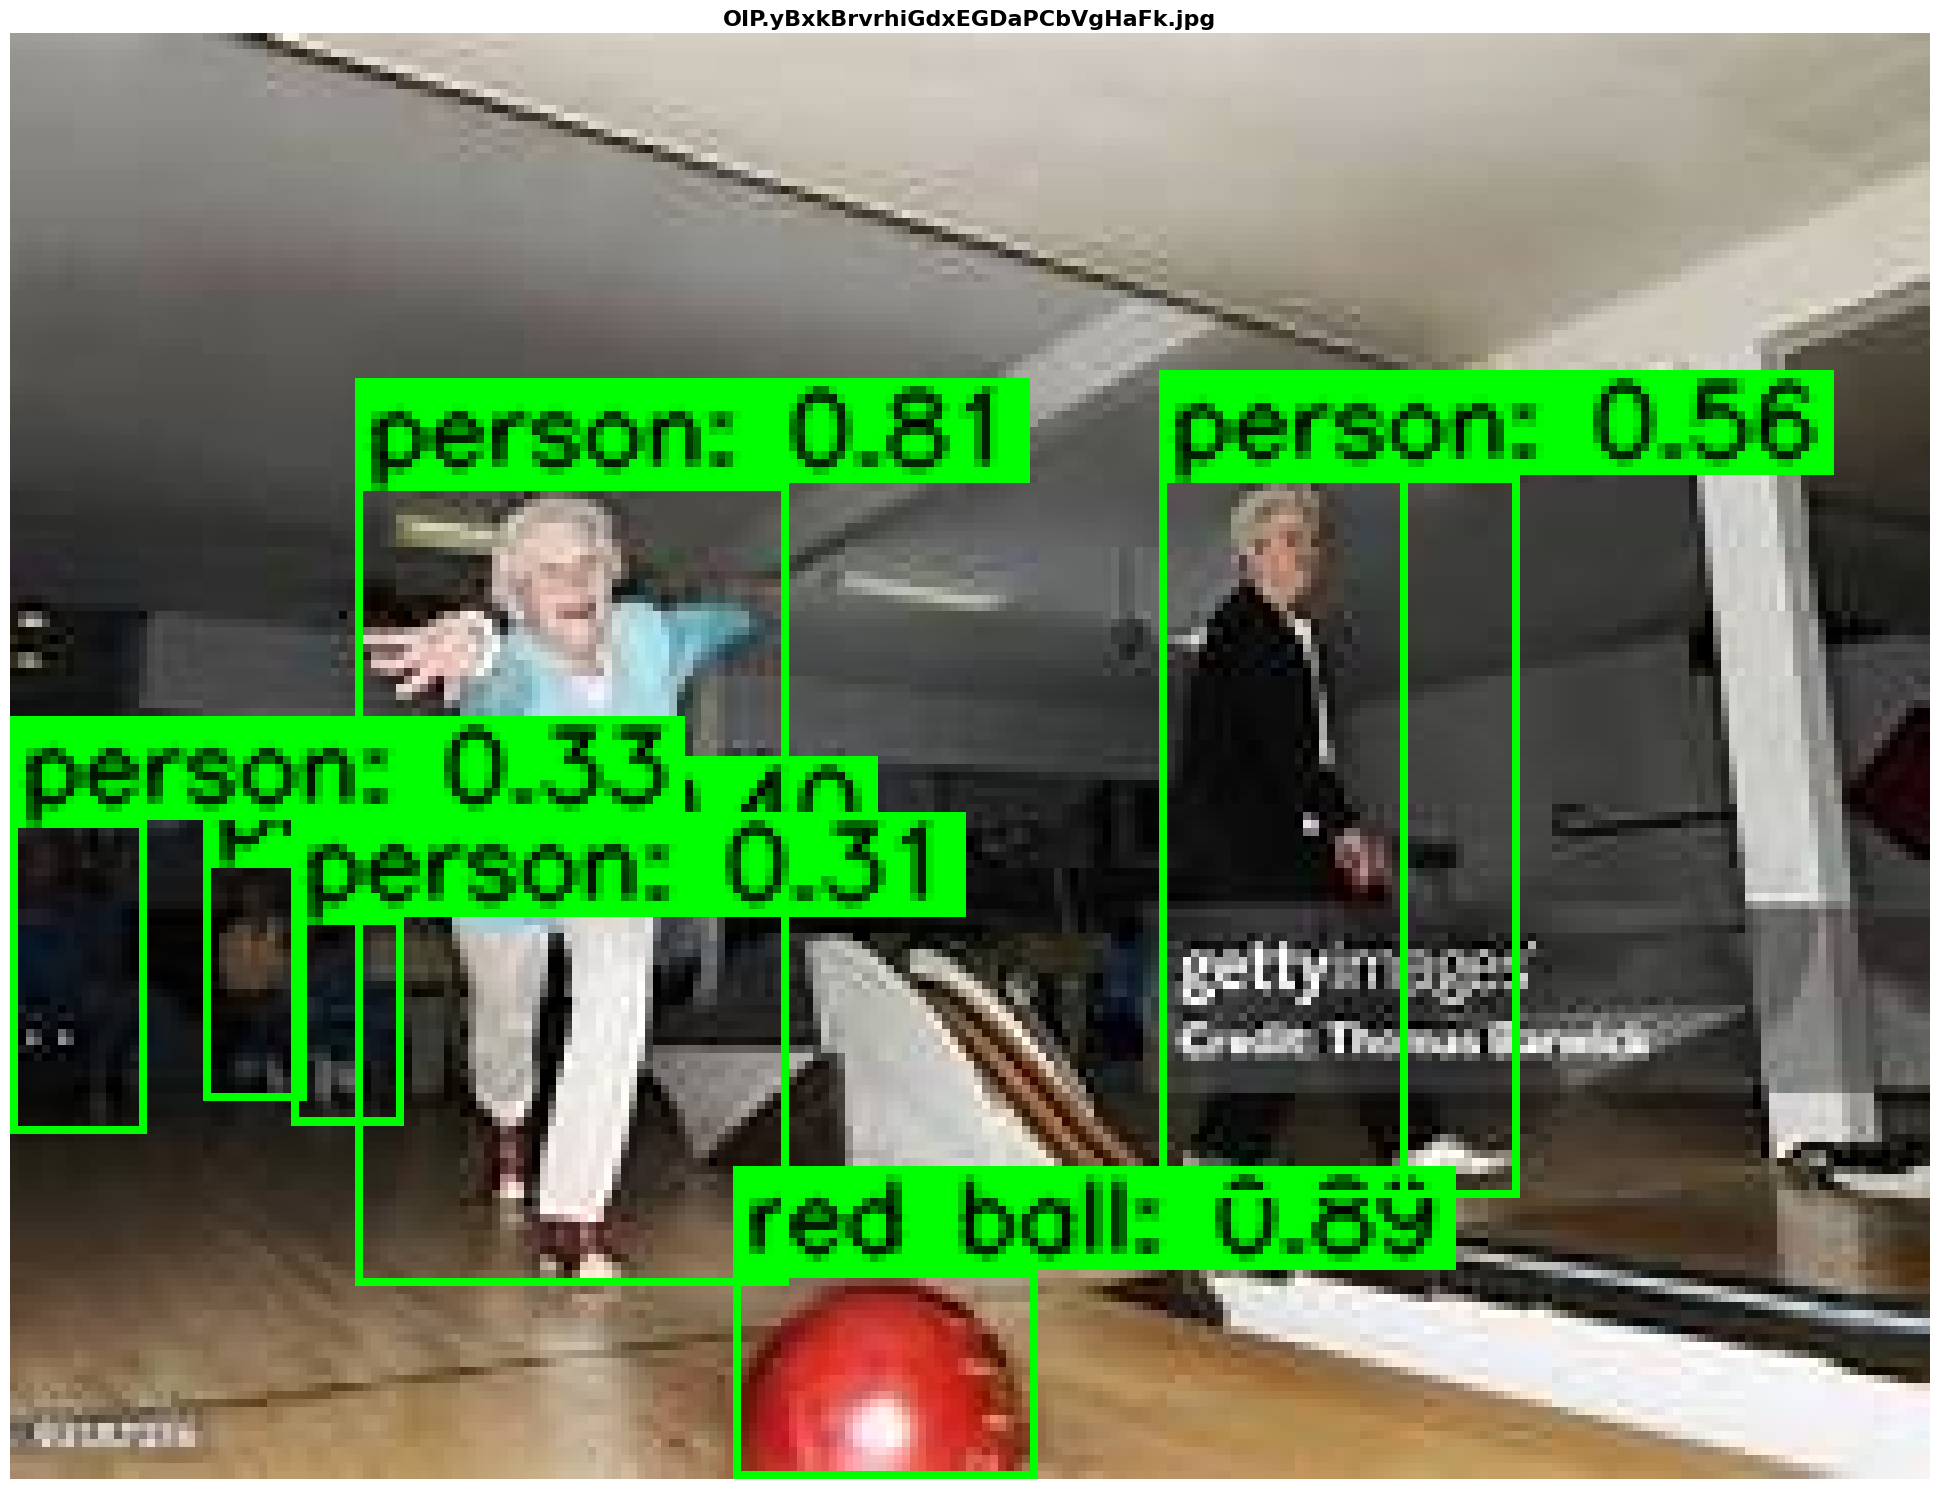

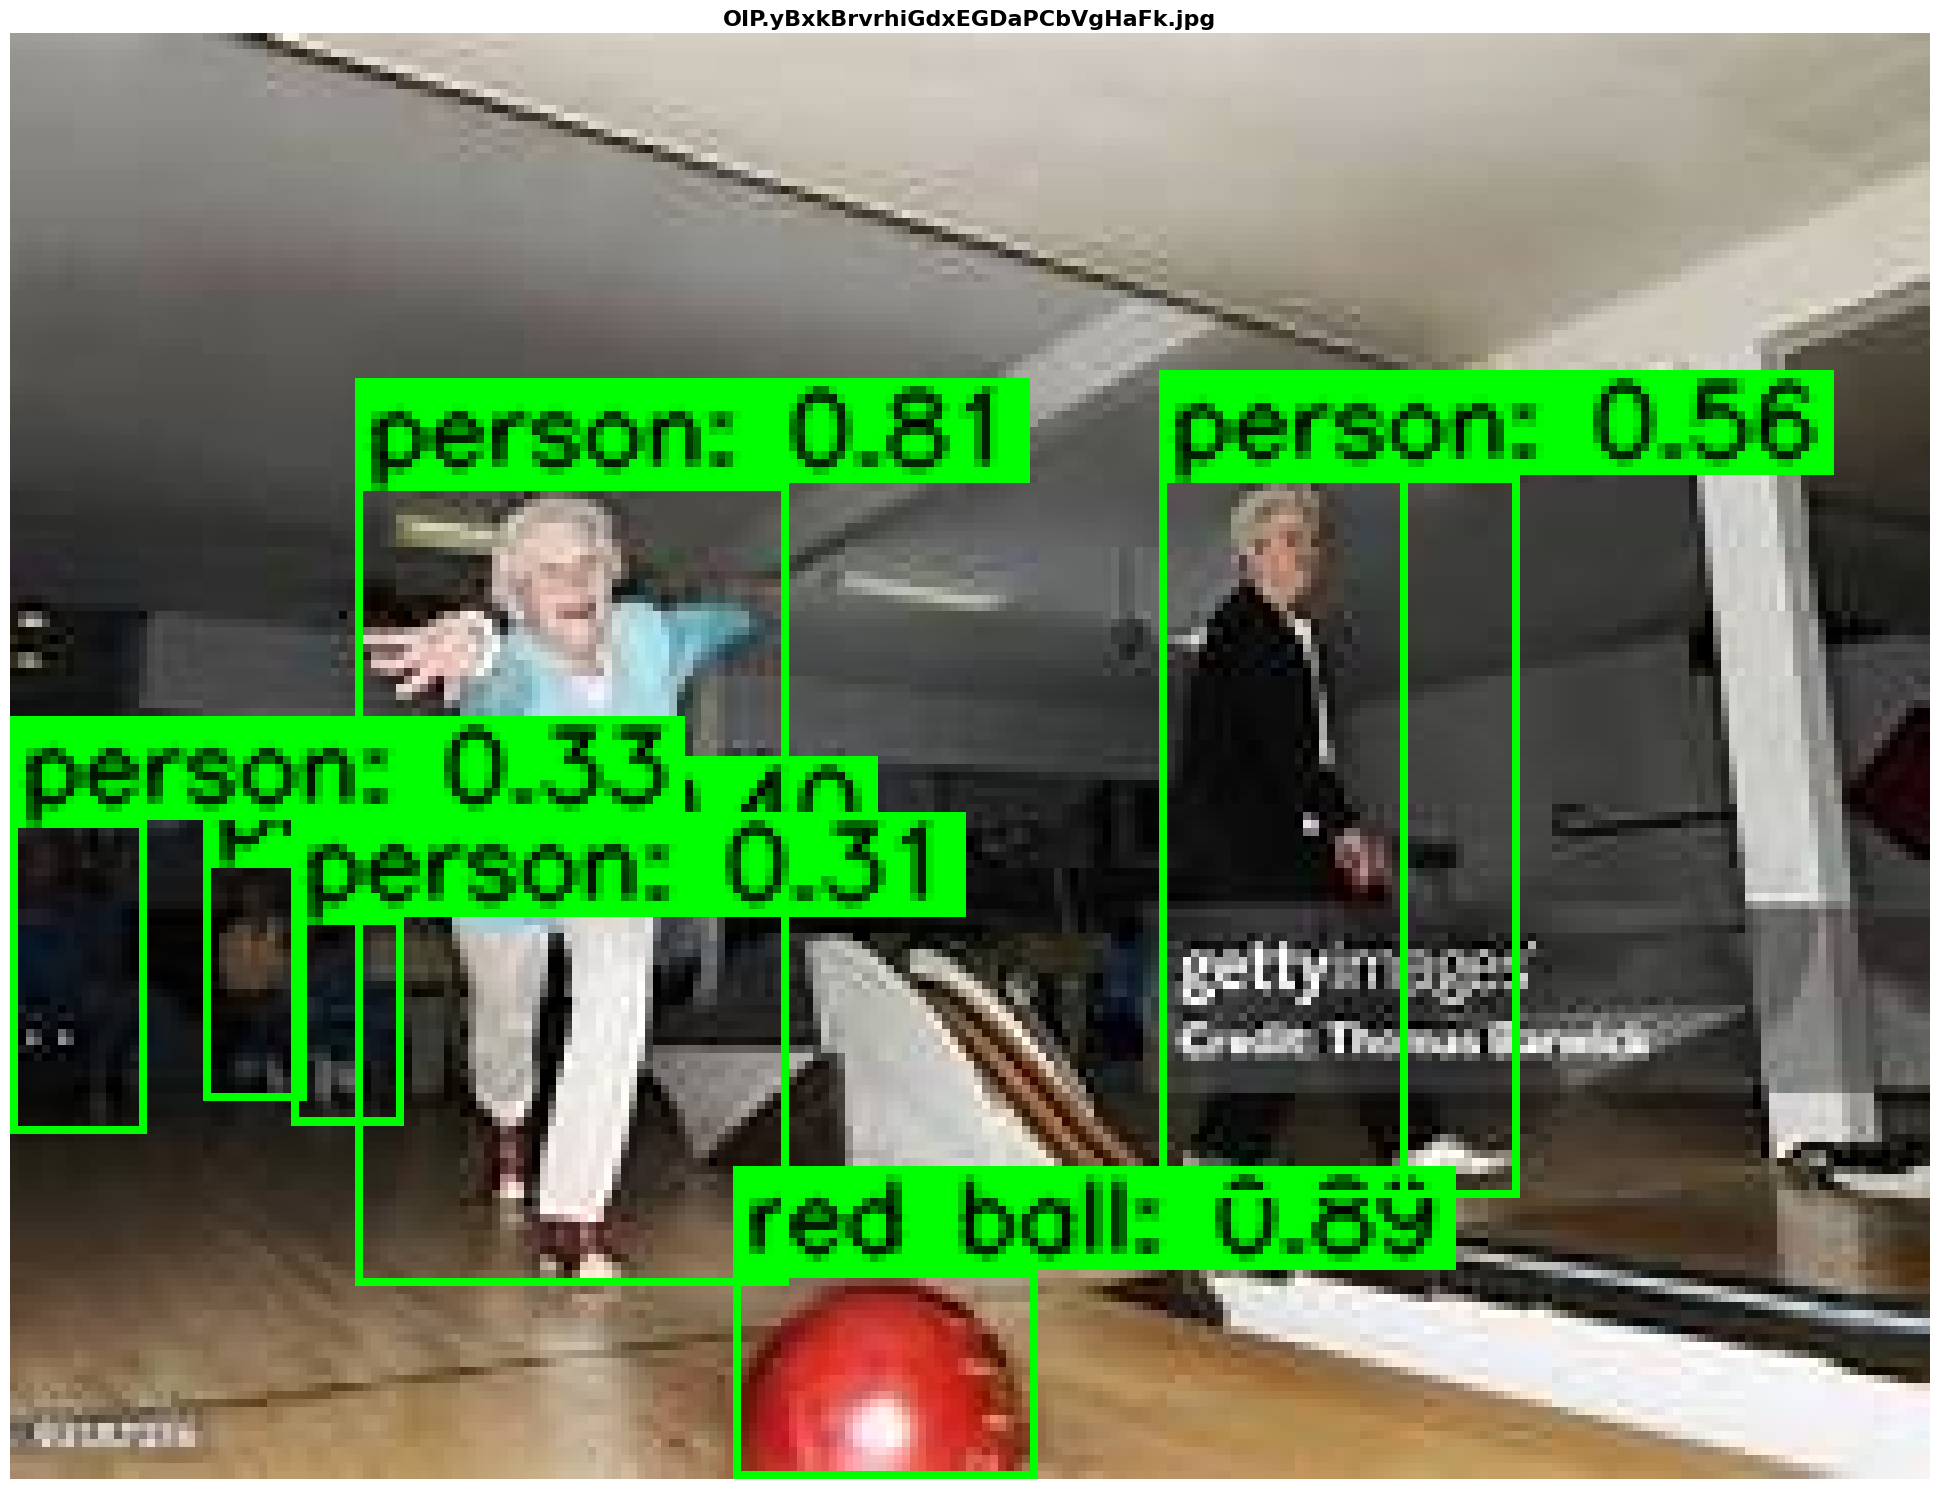

In [30]:
# img = Path("datasets/raw") / "IRL_validation_pictures" / "IMG_9698.JPG"
filename="OIP.yBxkBrvrhiGdxEGDaPCbVgHaFk.jpg"
img = Path("datasets/raw") / "red balls human yahoo" / filename

assert img.exists()
quick_test_gdino(img, 
    "red ball . person", 
    box_threshold=0.116, 
    text_threshold=0.2,
)

final text_encoder_type: bert-base-uncased
Found: 4 red ball, 2 person


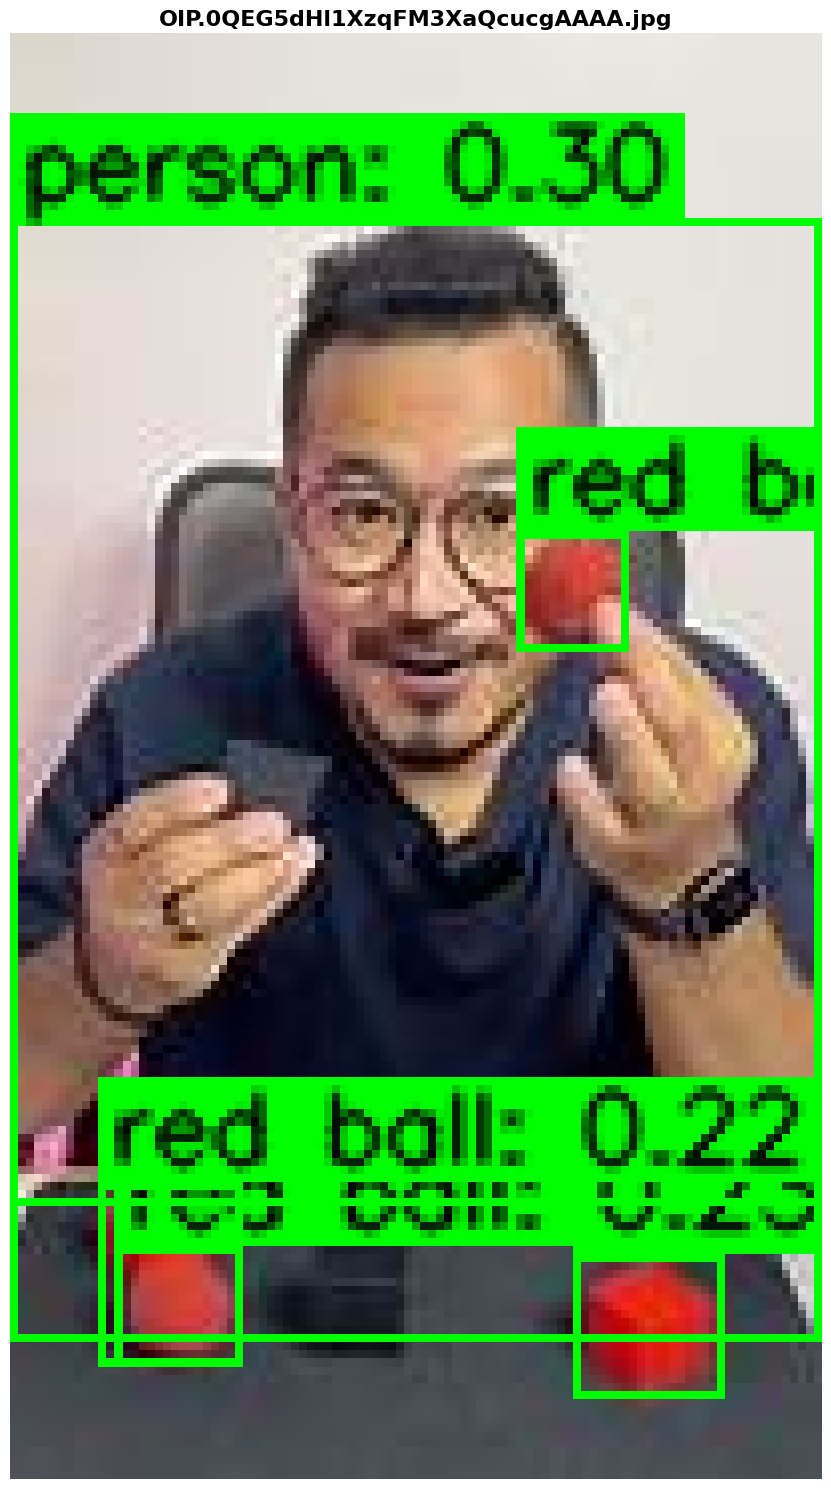

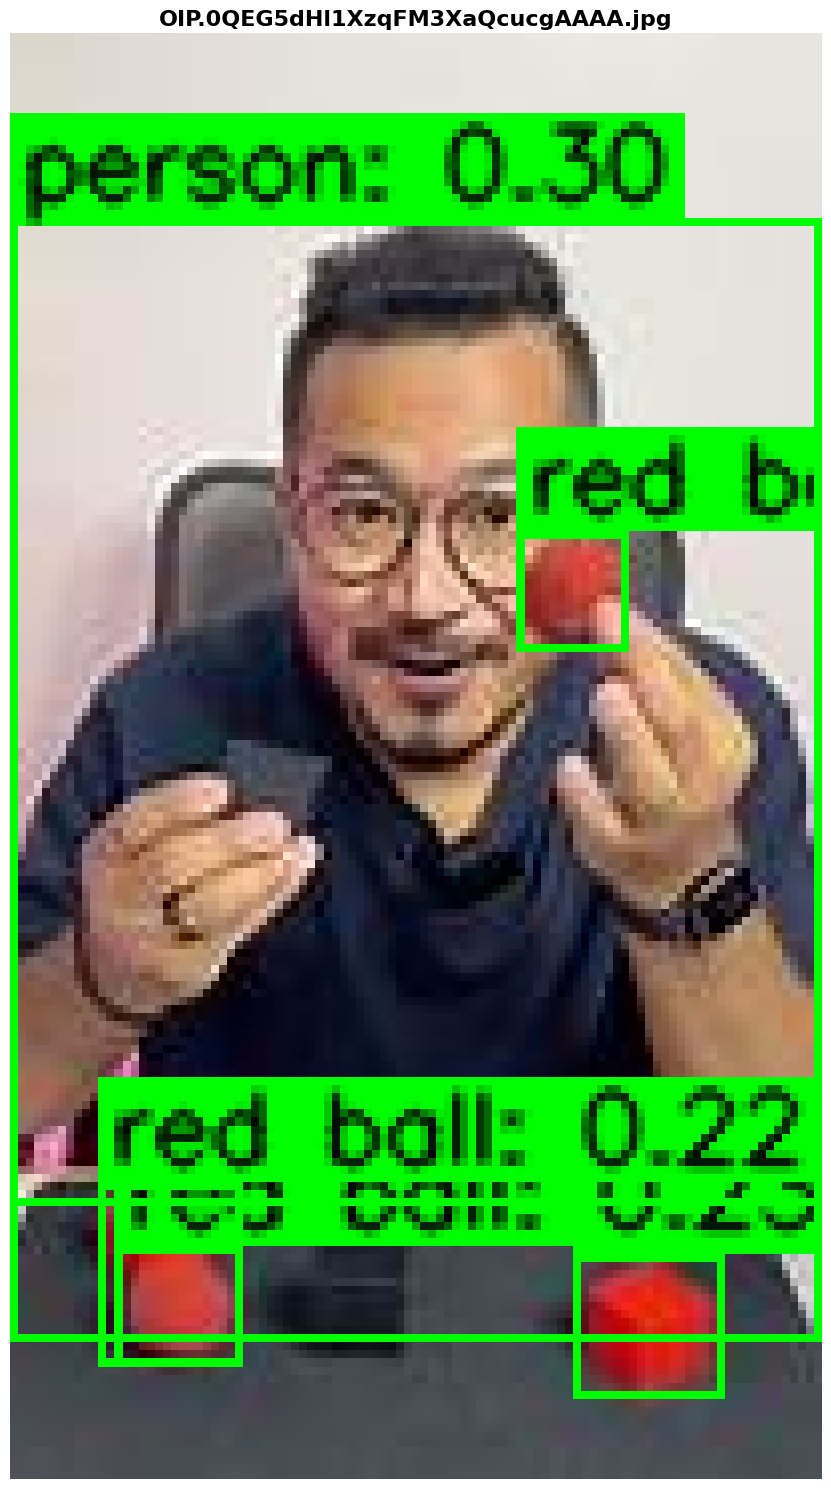

In [31]:
# img = Path("datasets/raw") / "IRL_validation_pictures" / "IMG_9698.JPG"
filename="OIP.0QEG5dHl1XzqFM3XaQcucgAAAA.jpg"
img = Path("datasets/raw") / "red balls human yahoo" / filename

assert img.exists()
quick_test_gdino(img, 
    "red ball . person", 
    box_threshold=0.116, 
    text_threshold=0.2,
)

<!-- ## Run Inference on Test Images -->

In [19]:
# # Lister toutes les images
# image_paths = list(TEST_IMAGES_DIR.glob("*.jpg")) + list(TEST_IMAGES_DIR.glob("*.jpeg"))
# image_paths += list(TEST_IMAGES_DIR.glob("*.JPG")) + list(TEST_IMAGES_DIR.glob("*.JPEG"))

# print(f"Found {len(image_paths)} test images")

# # Limiter à un nombre raisonnable pour la démo
# MAX_IMAGES = 10
# image_paths = image_paths[:MAX_IMAGES]

In [20]:
# # Traiter chaque image - Phase 1: GroundingDINO Detection
# results = []

# print("=" * 80)
# print("PHASE 1: GroundingDINO Detection")
# print("=" * 80)

# for img_path in tqdm(image_paths, desc="GroundingDINO detection"):
#     print(f"\nProcessing: {img_path.name}")
    
#     gdino_dets_dict = gdino.detect(img_path, DETECTION_PROMPT, return_all_by_label=True, debug=False)
    
#     # Flatten detections
#     gdino_dets = []
#     for label, dets in gdino_dets_dict.items():
#         gdino_dets.extend(dets)
    
#     print(f"  → Found {len(gdino_dets)} detections")
    
#     # Stocker les résultats
#     results.append({
#         'path': img_path,
#         'gdino_dets': gdino_dets,
#         'sam_masks': [],  # Sera rempli plus tard
#         'yolo_result': None  # Sera rempli plus tard
#     })

# print(f"\n✅ Phase 1 complete: {sum(len(r['gdino_dets']) for r in results)} total detections")
# print("=" * 80)

In [21]:
# # Comparaison finale avec tous les modèles
# num_to_display = min(3, len(results))

# for i in range(num_to_display):
#     r = results[i]
    
#     # Créer la visualisation complète
#     fig = visualize_comparison(r['path'], r['gdino_dets'])
    
#     # Sauvegarder
#     output_path = OUTPUT_DIR / f"{r['path'].stem}_comparison.png"
#     fig.savefig(output_path, dpi=100, bbox_inches='tight')
    
#     plt.show()
#     print(f"Saved to: {output_path}\n")

# print(f"✅ All comparisons saved to {OUTPUT_DIR}")

In [22]:
# sam = SAMSegmenter()

# print("\nLoading YOLOv11...")
# yolo = YOLO(YOLO_MODEL)
# print("✓ YOLOv11 loaded")

<!-- ### Comparaison finale: Tous les modèles -->

In [23]:
# # Phase 3: YOLOv11 Inference
# print("=" * 80)
# print("PHASE 3: YOLOv11 Detection")
# print("=" * 80)

# for r in tqdm(results, desc="YOLOv11 inference"):
#     img_path = r['path']
    
#     yolo_result = yolo(str(img_path), conf=YOLO_CONF, verbose=False)
#     r['yolo_result'] = yolo_result
    
#     num_dets = len(yolo_result[0].boxes) if yolo_result else 0
#     print(f"{img_path.name}: {num_dets} detections")

# total_yolo = sum(len(r['yolo_result'][0].boxes) if r['yolo_result'] else 0 for r in results)
# print(f"\n✅ Phase 3 complete: {total_yolo} total detections")
# print("=" * 80)

<!-- ### Phase 3: YOLOv11 (optionnel) -->

In [24]:
# # Afficher les résultats GroundingDINO + SAM2
# num_to_display = min(5, len(results))

# fig, axes = plt.subplots(num_to_display, 3, figsize=(20, 6 * num_to_display))
# if num_to_display == 1:
#     axes = axes.reshape(1, -1)

# for i in range(num_to_display):
#     r = results[i]
#     img_path = r['path']
#     gdino_dets = r['gdino_dets']
#     sam_masks = r['sam_masks']
    
#     # Charger l'image
#     image_bgr = cv2.imread(str(img_path))
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
#     # Original
#     axes[i, 0].imshow(image_rgb)
#     axes[i, 0].set_title(f'Original: {img_path.name}')
#     axes[i, 0].axis('off')
    
#     # GroundingDINO boxes
#     gdino_vis = draw_boxes(image_bgr, gdino_dets, color=(0, 255, 0), thickness=3)
#     gdino_vis_rgb = cv2.cvtColor(gdino_vis, cv2.COLOR_BGR2RGB)
#     axes[i, 1].imshow(gdino_vis_rgb)
#     axes[i, 1].set_title(f'GroundingDINO: {len(gdino_dets)} boxes')
#     axes[i, 1].axis('off')
    
#     # GroundingDINO + SAM2
#     if sam_masks:
#         sam_vis = draw_masks(image_bgr, sam_masks, alpha=0.4)
#         sam_vis = draw_boxes(sam_vis, gdino_dets, color=(255, 255, 0), thickness=2)
#         sam_vis_rgb = cv2.cvtColor(sam_vis, cv2.COLOR_BGR2RGB)
#         axes[i, 2].imshow(sam_vis_rgb)
#         axes[i, 2].set_title(f'GDINO + SAM2: {len(sam_masks)} masks')
#     else:
#         axes[i, 2].imshow(image_rgb)
#         axes[i, 2].set_title('GDINO + SAM2: no masks')
#     axes[i, 2].axis('off')

# plt.suptitle('Phase 2: GroundingDINO + SAM2 Segmentation Results', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()

<!-- # Afficher les résultats GroundingDINO + SAM2
num_to_display = min(5, len(results))

for i in range(num_to_display):
    r = results[i]
    img_path = r['path']
    gdino_dets = r['gdino_dets']
    sam_masks = r['sam_masks']
    
    # Utiliser la nouvelle fonction de visualisation avec masques
    print(f"\nResult for: {img_path.name}")
    fig = visualize_comparison(img_path, gdino_dets, sam_masks)
    plt.show() -->

In [25]:
# # Phase 2: SAM2 Segmentation guidée par GroundingDINO
# print("=" * 80)
# print("PHASE 2: SAM2 Segmentation")
# print("=" * 80)

# for r in tqdm(results, desc="SAM2 segmentation"):
#     img_path = r['path']
#     gdino_dets = r['gdino_dets']
    
#     print(f"\nProcessing: {img_path.name}")
    
#     if gdino_dets:
#         bboxes = [det['bbox'] for det in gdino_dets]
#         masks_result = sam.segment(img_path, bboxes)
#         if masks_result:
#             r['sam_masks'] = masks_result['masks']
#             print(f"  → Generated {len(r['sam_masks'])} masks")
#         else:
#             print("  → No masks generated")
#     else:
#         print("  → Skipped (no detections)")

# total_masks = sum(len(r['sam_masks']) for r in results)
# print(f"\n✅ Phase 2 complete: {total_masks} total masks")
# print("=" * 80)

<!-- ### Phase 2: GroundingDINO + SAM2 Segmentation -->

In [26]:
# # Afficher les résultats GroundingDINO
# num_to_display = min(5, len(results))

# for i in range(num_to_display):
#     r = results[i]
#     img_path = r['path']
#     gdino_dets = r['gdino_dets']
    
#     # Utiliser la nouvelle fonction de visualisation
#     print(f"\nResult for: {img_path.name}")
#     fig = visualize_comparison(img_path, gdino_dets)
#     plt.show()

<!-- ### Phase 1: Visualiser les détections GroundingDINO -->

<!-- ## Display Results Summary -->

In [27]:
# # Statistiques
# total_gdino = sum(len(r['gdino_dets']) for r in results)
# total_sam = sum(len(r['sam_masks']) for r in results)
# total_yolo = sum(len(r['yolo_result'][0].boxes) if r['yolo_result'] else 0 for r in results)

# print("\n" + "="*60)
# print("SUMMARY")
# print("="*60)
# print(f"Images processed: {len(results)}")
# print(f"\nTotal detections:")
# print(f"  - GroundingDINO: {total_gdino}")
# print(f"  - SAM2 masks: {total_sam}")
# print(f"  - YOLOv11: {total_yolo}")
# print(f"\nAverage per image:")
# print(f"  - GroundingDINO: {total_gdino/len(results):.1f}")
# print(f"  - SAM2: {total_sam/len(results):.1f}")
# print(f"  - YOLOv11: {total_yolo/len(results):.1f}")
# print("="*60)

<!-- ## Display Sample Comparisons -->

In [28]:
# # Afficher quelques exemples directement dans le notebook
# num_to_display = min(3, len(results))

# for i in range(num_to_display):
#     r = results[i]
#     # Visualisation avec masques si disponibles
#     fig = visualize_comparison(r['path'], r['gdino_dets'], r['sam_masks'])
#     plt.show()

<!-- ## Performance Comparison

### GroundingDINO + SAM2
**Avantages** :
- Zero-shot : fonctionne sans entraînement
- Flexible : peut détecter n'importe quelle classe avec un prompt
- Segmentation précise avec SAM2

**Inconvénients** :
- Plus lent (2 modèles)
- Nécessite des prompts bien formulés
- Peut nécessiter du tuning des seuils

### YOLOv11
**Avantages** :
- Rapide (1 seul modèle)
- Détection + segmentation en une passe
- Performance spécialisée sur les classes entraînées

**Inconvénients** :
- Nécessite un entraînement
- Limité aux classes du dataset d'entraînement
- Moins flexible -->